You should first run the Installing Libraries section before running this cell

In [0]:
import os
import torch
from torch import nn, optim
from torch.utils import data
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
from collections import OrderedDict
from progressbar import progressbar

%matplotlib inline

# Sync with Google Drive

Mounting the Google Drive data on the Jupyter Colab Notebook.

In [0]:
from google.colab import drive

drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
os.chdir('gdrive/My Drive/Udacity/FinalChallenge')

# Installing Libraries

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# !pip install --upgrade torch torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x586d8000 @  0x7fe932faa2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
!pip install progressbar2

In [0]:
torch.__version__

'0.4.1'

# Load Data

The data is split into two groups: *training* and *validation*. On the training set will be applied transformations such as random scaling, cropping and flipping. The input data should be sized 224x224 pixels, such as required to the pretrained network. The validation set is used to check the model's performance on data previously unseen. The data will be resized and then cropped to the regular size.

The pretrained networks available on the torchvision model zoo were trained on `ImageNet` dataset, where each color channel was normalized separately. 

For the mean: `[0.485, 0.456, 0.406]`.

For the standard deviations: `[0.229, 0.224, 0.225]`.

This values will shift each color channel to be centered at 0 and range from -1 to 1. 

In [0]:
base_path = 'data/flower_data/'
batch_size = 64

In [0]:
# Transforms
train_transforms = transforms.Compose([
    transforms.Resize(248),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(240),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset
train_dataset = datasets.ImageFolder(os.path.join(base_path, 'train'),
                                     transform=train_transforms)

valid_dataset = datasets.ImageFolder(os.path.join(base_path, 'valid'),
                                     transform=valid_transforms)

# DataLoader
train_loader = data.DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=8)

valid_loader = data.DataLoader(valid_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=8)

In [0]:
number_of_data = batch_size * len(train_loader)

print(f'There are a total of {number_of_data} pictures on the dataset.')

There are a total of 6560 pictures on the dataset.


## Label Mapping

Dictionary mapping the labels to the name of the flowers.

In [0]:
with open('data/cat_to_name.json') as f:
  cat_to_name = json.load(f)
  
name_to_cat = {}
for k, v in cat_to_name.items():
  name_to_cat[v] = k

# Model

The chosen model will be the ResNet152 pre-trained with `ImageNet` dataset.

The classifier part will be changed to, instead of classifying `ImageNet` labels, will be fine tuned to classify the types of flowers of this project.

Regular classifier block:
```python
(fc): Linear(in_features=2048, out_features=1000, bias=True)
  ```

In [0]:
def build_model():
  model = models.resnet152(pretrained=True)
  
  for param in model.parameters():
    param.requires_grad = False
  
  fc = nn.Sequential(OrderedDict([
      ('fc1', nn.Linear(2048, 1024)),
      ('relu', nn.ReLU()),
      ('dropout', nn.Dropout(0.5)),
      ('fc2', nn.Linear(1024, 512)),
      ('relu', nn.ReLU()),
      ('dropout', nn.Dropout(0.5)),
      ('output', nn.Linear(512, 102))
  ]))
  
  model.fc = fc
  
  return model

## Training V1

Validation Accuracy: $\mathbf{92.96}\%$.


In [0]:
epochs = 50
lr = 0.001

In [0]:
optimizer = optim.Adagrad(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  model.cuda()

NameError: ignored

Training the model.

In [0]:
valid_loss_min = np.Inf # Checking the minimum loss to save the current best model
version = 1

training_losses = []
valid_losses = []
epochs_versions = []

for e in range(1, epochs+1):
  train_loss = 0.0
  valid_loss = 0.0
  
  model.train()
  
  for x, y in progressbar(train_loader):
    # Moving data to GPU
    if train_on_gpu:
      x, y = x.cuda(), y.cuda()
    
    # Set the gradients to zero
    optimizer.zero_grad()
    
    # Forward Pass
    output = model(x)
    
    # Loss
    loss = criterion(output, y)
    
    # Backward Pass
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item() * x.size(0)
    
  # After each epoch append the training loss to the array
  train_loss = train_loss / len(train_loader.dataset)
  training_losses.append(train_loss)
  
  # Change to evaluation mode
  model.eval()
  val_acc = 0
  
  for x, y in valid_loader:
    if train_on_gpu:
      x, y = x.cuda(), y.cuda()
    
    # Forward pass
    output = model(x)
    
    # Loss
    loss = criterion(output, y)
    
    # Check loss
    valid_loss += loss.item() * x.size(0)
    
    # Check accuracy
    _, top_class = output.topk(1, dim=1)
    equals = top_class == y.view(*top_class.shape)
    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
    
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\tValidation Accuracy: {:.2f}%'.format(e, train_loss, valid_loss, 100*val_acc/len(valid_loader)))
  if valid_loss < valid_loss_min:
    print('\tVersion ' + str(version) + ', validation loss decreased: {} --> {}'.format(
        valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'model_100_version_' + str(version) + '.pt')
    valid_loss_min = valid_loss
    version += 1
    epochs_versions.append(e)
    
  # Saving loss per epoch
  valid_loss = valid_loss / len(valid_loader.dataset)
  valid_losses.append(valid_loss)

100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 1 	Training Loss: 0.299755 	Validation Loss: 251.361451	Validation Accuracy: 91.92%
	Version 1, validation loss decreased: inf --> 251.36145091056824


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 2 	Training Loss: 0.292733 	Validation Loss: 241.266425	Validation Accuracy: 91.69%
	Version 2, validation loss decreased: 251.36145091056824 --> 241.2664247751236


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 3 	Training Loss: 0.290953 	Validation Loss: 246.684904	Validation Accuracy: 92.05%


100% (103 of 103) |######################| Elapsed Time: 0:02:01 Time:  0:02:01


Epoch: 4 	Training Loss: 0.291283 	Validation Loss: 251.605958	Validation Accuracy: 91.61%


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 5 	Training Loss: 0.290072 	Validation Loss: 246.676927	Validation Accuracy: 91.54%


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 6 	Training Loss: 0.296358 	Validation Loss: 249.914078	Validation Accuracy: 91.26%


100% (103 of 103) |######################| Elapsed Time: 0:02:01 Time:  0:02:01


Epoch: 7 	Training Loss: 0.289990 	Validation Loss: 241.188464	Validation Accuracy: 91.75%
	Version 3, validation loss decreased: 241.2664247751236 --> 241.18846410512924


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 8 	Training Loss: 0.282847 	Validation Loss: 241.270343	Validation Accuracy: 91.99%


100% (103 of 103) |######################| Elapsed Time: 0:02:01 Time:  0:02:01


Epoch: 9 	Training Loss: 0.285811 	Validation Loss: 251.958839	Validation Accuracy: 91.49%


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 10 	Training Loss: 0.290307 	Validation Loss: 243.432337	Validation Accuracy: 91.40%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 11 	Training Loss: 0.283868 	Validation Loss: 244.327669	Validation Accuracy: 92.41%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 12 	Training Loss: 0.273036 	Validation Loss: 243.653392	Validation Accuracy: 91.88%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 13 	Training Loss: 0.287438 	Validation Loss: 239.765863	Validation Accuracy: 91.97%
	Version 4, validation loss decreased: 241.18846410512924 --> 239.76586323976517


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 14 	Training Loss: 0.279112 	Validation Loss: 249.485317	Validation Accuracy: 91.21%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 15 	Training Loss: 0.287081 	Validation Loss: 238.519675	Validation Accuracy: 92.17%
	Version 5, validation loss decreased: 239.76586323976517 --> 238.5196751356125


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 16 	Training Loss: 0.274169 	Validation Loss: 242.312336	Validation Accuracy: 92.50%


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 17 	Training Loss: 0.285603 	Validation Loss: 241.065796	Validation Accuracy: 92.26%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 18 	Training Loss: 0.278534 	Validation Loss: 246.611820	Validation Accuracy: 91.85%


100% (103 of 103) |######################| Elapsed Time: 0:02:02 Time:  0:02:02


Epoch: 19 	Training Loss: 0.285715 	Validation Loss: 239.581634	Validation Accuracy: 92.02%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 20 	Training Loss: 0.286644 	Validation Loss: 245.103015	Validation Accuracy: 92.14%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 21 	Training Loss: 0.275290 	Validation Loss: 244.449036	Validation Accuracy: 91.78%


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 22 	Training Loss: 0.276844 	Validation Loss: 236.859923	Validation Accuracy: 92.84%
	Version 6, validation loss decreased: 238.5196751356125 --> 236.859923183918


100% (103 of 103) |######################| Elapsed Time: 0:02:03 Time:  0:02:03


Epoch: 23 	Training Loss: 0.270322 	Validation Loss: 247.139785	Validation Accuracy: 91.61%


 22% (23 of 103) |#####                  | Elapsed Time: 0:00:27 ETA:   0:01:36

In [0]:
train_loss = np.concatenate([train_loss, train_loss_2])
valid_loss = np.concatenate([valid_loss, valid_loss_2])

Text(0.5,1,'Training Loss 92.84%')

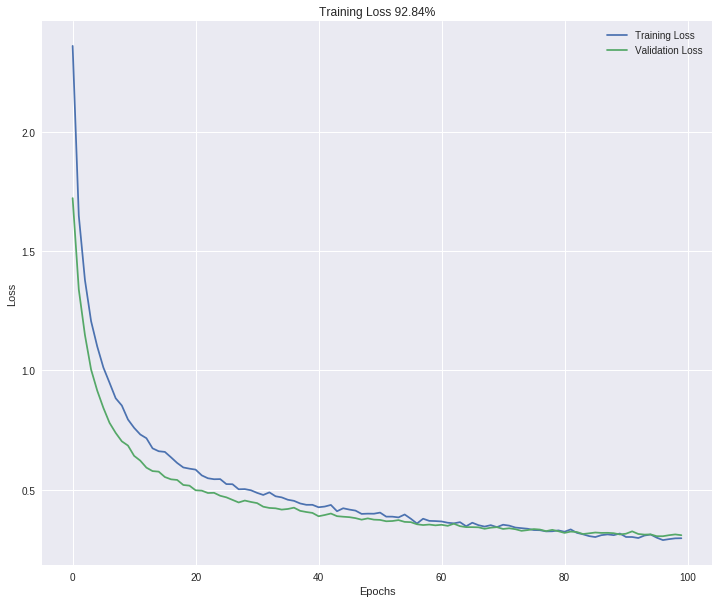

In [0]:
plt.figure(figsize=(12.0, 10.0))

plt.plot(train_loss)
plt.plot(valid_loss)

plt.legend(['Training Loss', 'Validation Loss'])

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training Loss 92.84%')

## Training V2

Validation Accuracy: $\mathbf{97.96}\%$

In [0]:
epochs = 100
lr = 0.1

In [0]:
model = build_model()

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  model.cuda()

optimizer = optim.Adadelta(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [0]:
# Checking the minimum loss to save the current best model
valid_loss_min = np.Inf
version = 1

training_losses = []
valid_losses = []

for e in range(1, epochs+1):
  train_loss = 0.0
  valid_loss = 0.0
  
  model.train()
  
  for x, y in progressbar(train_loader):
    # Moving data to GPU
    x, y = x.cuda(), y.cuda()
    
    # Set the gradients to zero
    optimizer.zero_grad()
    
    # Forward Pass
    output = model(x)
    
    # Loss
    loss = criterion(output, y)
    
    # Backward Pass
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item() * x.size(0)
    
  train_loss = train_loss / len(train_loader.dataset)
  training_losses.append(train_loss)
  
  # Change to evaluation mode
  val_acc = 0.0
  model.eval()
  
  for x, y in valid_loader:
    if train_on_gpu:
      x, y = x.cuda(), y.cuda()
      
    output = model(x)
    softmax = nn.Softmax(dim=1)
    
    # Getting the loss
    val_loss = criterion(output, y)
    
    # Getting the accuracy
    probs = softmax(output)
    _, predictions = probs.topk(1, dim=1)
    right_predictions = predictions == y.view(*predictions.shape)
    val_acc += torch.mean(right_predictions.type(torch.FloatTensor)).item()
    
    valid_loss += val_loss.item() * x.size(0)
    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    
  # Print summary
  print('Epoch {}: \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(
    e,
    train_loss,
    valid_loss,
    100*val_acc/len(valid_loader)
  ))
  
  if valid_loss < valid_loss_min:
    print('Version {}: Validation loss decreased {} --> {}'.format(
      version,
      valid_loss_min,
      valid_loss
    ))
    
    valid_loss_min = valid_loss
    torch.save(model.state_dict(), 'model_v2_' + str(version) + '.pt')
    version += 1

100% (103 of 103) |######################| Elapsed Time: 0:01:49 Time:  0:01:49


Epoch 1: 	Training Loss: 4.108741 	Validation Loss: 0.202526 	Validation Accuracy: 32.03%
Version 1: Validation loss decreased inf --> 0.20252625926639528


100% (103 of 103) |######################| Elapsed Time: 0:01:49 Time:  0:01:49


Epoch 2: 	Training Loss: 2.616270 	Validation Loss: 0.125314 	Validation Accuracy: 55.31%
Version 2: Validation loss decreased 0.20252625926639528 --> 0.12531422145428908


100% (103 of 103) |######################| Elapsed Time: 0:01:50 Time:  0:01:50


Epoch 3: 	Training Loss: 1.606618 	Validation Loss: 0.086372 	Validation Accuracy: 71.66%
Version 3: Validation loss decreased 0.12531422145428908 --> 0.08637231243939213


100% (103 of 103) |######################| Elapsed Time: 0:01:50 Time:  0:01:50


Epoch 4: 	Training Loss: 1.134186 	Validation Loss: 0.061684 	Validation Accuracy: 78.10%
Version 4: Validation loss decreased 0.08637231243939213 --> 0.06168418455319338


100% (103 of 103) |######################| Elapsed Time: 0:01:49 Time:  0:01:49


Epoch 5: 	Training Loss: 0.888811 	Validation Loss: 0.039860 	Validation Accuracy: 84.50%
Version 5: Validation loss decreased 0.06168418455319338 --> 0.039859505006716305


100% (103 of 103) |######################| Elapsed Time: 0:01:49 Time:  0:01:49


Epoch 6: 	Training Loss: 0.746150 	Validation Loss: 0.036096 	Validation Accuracy: 83.06%
Version 6: Validation loss decreased 0.039859505006716305 --> 0.03609555587489483


100% (103 of 103) |######################| Elapsed Time: 0:01:49 Time:  0:01:49


Epoch 7: 	Training Loss: 0.649465 	Validation Loss: 0.026429 	Validation Accuracy: 86.03%
Version 7: Validation loss decreased 0.03609555587489483 --> 0.026429097875306735


100% (103 of 103) |######################| Elapsed Time: 0:01:51 Time:  0:01:51


Epoch 8: 	Training Loss: 0.568327 	Validation Loss: 0.047192 	Validation Accuracy: 89.19%


100% (103 of 103) |######################| Elapsed Time: 0:01:49 Time:  0:01:49


Epoch 9: 	Training Loss: 0.511837 	Validation Loss: 0.030642 	Validation Accuracy: 82.66%


100% (103 of 103) |######################| Elapsed Time: 0:01:48 Time:  0:01:48


Epoch 10: 	Training Loss: 0.467562 	Validation Loss: 0.027099 	Validation Accuracy: 88.17%


100% (103 of 103) |######################| Elapsed Time: 0:01:49 Time:  0:01:49


Epoch 11: 	Training Loss: 0.444501 	Validation Loss: 0.030670 	Validation Accuracy: 87.45%


100% (103 of 103) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


Epoch 12: 	Training Loss: 0.408967 	Validation Loss: 0.022887 	Validation Accuracy: 90.10%
Version 8: Validation loss decreased 0.026429097875306735 --> 0.0228868011558725


100% (103 of 103) |######################| Elapsed Time: 0:01:54 Time:  0:01:54


Epoch 13: 	Training Loss: 0.398756 	Validation Loss: 0.023042 	Validation Accuracy: 90.10%


100% (103 of 103) |######################| Elapsed Time: 0:01:54 Time:  0:01:54


Epoch 14: 	Training Loss: 0.376352 	Validation Loss: 0.027711 	Validation Accuracy: 91.54%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 15: 	Training Loss: 0.347712 	Validation Loss: 0.020457 	Validation Accuracy: 90.04%
Version 9: Validation loss decreased 0.0228868011558725 --> 0.02045689105881206


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 16: 	Training Loss: 0.332360 	Validation Loss: 0.015499 	Validation Accuracy: 90.94%
Version 10: Validation loss decreased 0.02045689105881206 --> 0.015498841254880115


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 17: 	Training Loss: 0.317452 	Validation Loss: 0.011901 	Validation Accuracy: 91.04%
Version 11: Validation loss decreased 0.015498841254880115 --> 0.01190146790379118


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 18: 	Training Loss: 0.308226 	Validation Loss: 0.016083 	Validation Accuracy: 90.40%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 19: 	Training Loss: 0.291453 	Validation Loss: 0.016325 	Validation Accuracy: 89.65%


100% (103 of 103) |######################| Elapsed Time: 0:01:54 Time:  0:01:54


Epoch 20: 	Training Loss: 0.280092 	Validation Loss: 0.013603 	Validation Accuracy: 91.61%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 21: 	Training Loss: 0.276220 	Validation Loss: 0.017899 	Validation Accuracy: 91.93%


100% (103 of 103) |######################| Elapsed Time: 0:01:54 Time:  0:01:54


Epoch 22: 	Training Loss: 0.259718 	Validation Loss: 0.015041 	Validation Accuracy: 91.00%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 23: 	Training Loss: 0.249555 	Validation Loss: 0.014585 	Validation Accuracy: 91.81%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 24: 	Training Loss: 0.248485 	Validation Loss: 0.015957 	Validation Accuracy: 92.02%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 25: 	Training Loss: 0.244624 	Validation Loss: 0.023185 	Validation Accuracy: 92.35%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 26: 	Training Loss: 0.231102 	Validation Loss: 0.016510 	Validation Accuracy: 91.97%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 27: 	Training Loss: 0.229505 	Validation Loss: 0.009744 	Validation Accuracy: 92.69%
Version 12: Validation loss decreased 0.01190146790379118 --> 0.009744486111477895


100% (103 of 103) |######################| Elapsed Time: 0:01:56 Time:  0:01:56


Epoch 28: 	Training Loss: 0.228797 	Validation Loss: 0.011116 	Validation Accuracy: 92.72%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 29: 	Training Loss: 0.221835 	Validation Loss: 0.008770 	Validation Accuracy: 92.24%
Version 13: Validation loss decreased 0.009744486111477895 --> 0.008770088073814493


100% (103 of 103) |######################| Elapsed Time: 0:01:56 Time:  0:01:56


Epoch 30: 	Training Loss: 0.223253 	Validation Loss: 0.011242 	Validation Accuracy: 92.63%


100% (103 of 103) |######################| Elapsed Time: 0:01:56 Time:  0:01:56


Epoch 31: 	Training Loss: 0.206232 	Validation Loss: 0.011526 	Validation Accuracy: 93.05%


100% (103 of 103) |######################| Elapsed Time: 0:01:57 Time:  0:01:57


Epoch 32: 	Training Loss: 0.196682 	Validation Loss: 0.015537 	Validation Accuracy: 93.25%


100% (103 of 103) |######################| Elapsed Time: 0:01:56 Time:  0:01:56


Epoch 33: 	Training Loss: 0.193346 	Validation Loss: 0.026755 	Validation Accuracy: 91.71%


100% (103 of 103) |######################| Elapsed Time: 0:01:56 Time:  0:01:56


Epoch 34: 	Training Loss: 0.187473 	Validation Loss: 0.019212 	Validation Accuracy: 92.81%


100% (103 of 103) |######################| Elapsed Time: 0:01:56 Time:  0:01:56


Epoch 35: 	Training Loss: 0.183983 	Validation Loss: 0.041234 	Validation Accuracy: 92.33%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 36: 	Training Loss: 0.178738 	Validation Loss: 0.023315 	Validation Accuracy: 91.87%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 37: 	Training Loss: 0.179626 	Validation Loss: 0.017115 	Validation Accuracy: 92.59%


100% (103 of 103) |######################| Elapsed Time: 0:01:49 Time:  0:01:49


Epoch 38: 	Training Loss: 0.175787 	Validation Loss: 0.010961 	Validation Accuracy: 92.57%


100% (103 of 103) |######################| Elapsed Time: 0:01:48 Time:  0:01:48


Epoch 39: 	Training Loss: 0.165640 	Validation Loss: 0.013194 	Validation Accuracy: 91.93%


100% (103 of 103) |######################| Elapsed Time: 0:01:47 Time:  0:01:47


Epoch 40: 	Training Loss: 0.172368 	Validation Loss: 0.017858 	Validation Accuracy: 93.38%


100% (103 of 103) |######################| Elapsed Time: 0:01:47 Time:  0:01:47


Epoch 41: 	Training Loss: 0.165759 	Validation Loss: 0.017235 	Validation Accuracy: 92.77%


100% (103 of 103) |######################| Elapsed Time: 0:01:46 Time:  0:01:46


Epoch 42: 	Training Loss: 0.158378 	Validation Loss: 0.008104 	Validation Accuracy: 93.20%
Version 14: Validation loss decreased 0.008770088073814493 --> 0.00810447241977677


100% (103 of 103) |######################| Elapsed Time: 0:01:46 Time:  0:01:46


Epoch 43: 	Training Loss: 0.156920 	Validation Loss: 0.012193 	Validation Accuracy: 93.89%


100% (103 of 103) |######################| Elapsed Time: 0:01:46 Time:  0:01:46


Epoch 44: 	Training Loss: 0.154337 	Validation Loss: 0.018804 	Validation Accuracy: 91.47%


100% (103 of 103) |######################| Elapsed Time: 0:01:48 Time:  0:01:48


Epoch 45: 	Training Loss: 0.145208 	Validation Loss: 0.010145 	Validation Accuracy: 92.41%


100% (103 of 103) |######################| Elapsed Time: 0:01:51 Time:  0:01:51


Epoch 46: 	Training Loss: 0.149170 	Validation Loss: 0.014183 	Validation Accuracy: 92.95%


100% (103 of 103) |######################| Elapsed Time: 0:01:50 Time:  0:01:50


Epoch 47: 	Training Loss: 0.152331 	Validation Loss: 0.012610 	Validation Accuracy: 92.89%


100% (103 of 103) |######################| Elapsed Time: 0:01:48 Time:  0:01:48


Epoch 48: 	Training Loss: 0.153413 	Validation Loss: 0.011538 	Validation Accuracy: 93.32%


100% (103 of 103) |######################| Elapsed Time: 0:01:48 Time:  0:01:48


Epoch 49: 	Training Loss: 0.146996 	Validation Loss: 0.028869 	Validation Accuracy: 92.43%


100% (103 of 103) |######################| Elapsed Time: 0:01:48 Time:  0:01:48


Epoch 50: 	Training Loss: 0.147118 	Validation Loss: 0.011800 	Validation Accuracy: 92.62%


100% (103 of 103) |######################| Elapsed Time: 0:01:49 Time:  0:01:49


Epoch 51: 	Training Loss: 0.137390 	Validation Loss: 0.009256 	Validation Accuracy: 93.65%


100% (103 of 103) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


Epoch 52: 	Training Loss: 0.134384 	Validation Loss: 0.001291 	Validation Accuracy: 93.63%
Version 15: Validation loss decreased 0.00810447241977677 --> 0.001290809630387155


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 53: 	Training Loss: 0.134108 	Validation Loss: 0.051159 	Validation Accuracy: 93.70%


100% (103 of 103) |######################| Elapsed Time: 0:01:54 Time:  0:01:54


Epoch 54: 	Training Loss: 0.129394 	Validation Loss: 0.009901 	Validation Accuracy: 93.68%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 55: 	Training Loss: 0.129563 	Validation Loss: 0.022122 	Validation Accuracy: 93.43%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 56: 	Training Loss: 0.126209 	Validation Loss: 0.016713 	Validation Accuracy: 93.13%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 57: 	Training Loss: 0.136794 	Validation Loss: 0.018843 	Validation Accuracy: 92.74%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 58: 	Training Loss: 0.128574 	Validation Loss: 0.015733 	Validation Accuracy: 92.43%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 59: 	Training Loss: 0.113969 	Validation Loss: 0.015250 	Validation Accuracy: 93.62%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 60: 	Training Loss: 0.120629 	Validation Loss: 0.015323 	Validation Accuracy: 94.25%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 61: 	Training Loss: 0.127867 	Validation Loss: 0.018091 	Validation Accuracy: 92.81%


100% (103 of 103) |######################| Elapsed Time: 0:01:54 Time:  0:01:54


Epoch 62: 	Training Loss: 0.107950 	Validation Loss: 0.048934 	Validation Accuracy: 93.00%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 63: 	Training Loss: 0.112694 	Validation Loss: 0.018085 	Validation Accuracy: 93.25%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 64: 	Training Loss: 0.113863 	Validation Loss: 0.045777 	Validation Accuracy: 93.41%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 65: 	Training Loss: 0.103578 	Validation Loss: 0.010166 	Validation Accuracy: 93.32%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 66: 	Training Loss: 0.108607 	Validation Loss: 0.004732 	Validation Accuracy: 94.20%


100% (103 of 103) |######################| Elapsed Time: 0:01:54 Time:  0:01:54


Epoch 67: 	Training Loss: 0.112560 	Validation Loss: 0.023403 	Validation Accuracy: 93.43%


100% (103 of 103) |######################| Elapsed Time: 0:01:54 Time:  0:01:54


Epoch 68: 	Training Loss: 0.113057 	Validation Loss: 0.023071 	Validation Accuracy: 93.19%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 69: 	Training Loss: 0.109271 	Validation Loss: 0.014224 	Validation Accuracy: 94.10%


100% (103 of 103) |######################| Elapsed Time: 0:01:55 Time:  0:01:55


Epoch 70: 	Training Loss: 0.112232 	Validation Loss: 0.011422 	Validation Accuracy: 94.25%


100% (103 of 103) |######################| Elapsed Time: 0:01:54 Time:  0:01:54


Epoch 71: 	Training Loss: 0.113421 	Validation Loss: 0.013139 	Validation Accuracy: 92.98%


100% (103 of 103) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


Epoch 72: 	Training Loss: 0.102720 	Validation Loss: 0.012386 	Validation Accuracy: 92.89%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 73: 	Training Loss: 0.103311 	Validation Loss: 0.010893 	Validation Accuracy: 93.05%


100% (103 of 103) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


Epoch 74: 	Training Loss: 0.096793 	Validation Loss: 0.020187 	Validation Accuracy: 92.74%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 75: 	Training Loss: 0.103302 	Validation Loss: 0.042725 	Validation Accuracy: 93.89%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 76: 	Training Loss: 0.105844 	Validation Loss: 0.013911 	Validation Accuracy: 94.34%


100% (103 of 103) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


Epoch 77: 	Training Loss: 0.096460 	Validation Loss: 0.017752 	Validation Accuracy: 94.58%


100% (103 of 103) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


Epoch 78: 	Training Loss: 0.095575 	Validation Loss: 0.011344 	Validation Accuracy: 93.50%


100% (103 of 103) |######################| Elapsed Time: 0:01:49 Time:  0:01:49


Epoch 79: 	Training Loss: 0.100902 	Validation Loss: 0.011759 	Validation Accuracy: 93.65%


100% (103 of 103) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


Epoch 80: 	Training Loss: 0.101499 	Validation Loss: 0.007484 	Validation Accuracy: 93.08%


100% (103 of 103) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


Epoch 81: 	Training Loss: 0.087530 	Validation Loss: 0.014899 	Validation Accuracy: 93.89%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 82: 	Training Loss: 0.084504 	Validation Loss: 0.015509 	Validation Accuracy: 93.58%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 83: 	Training Loss: 0.095401 	Validation Loss: 0.014532 	Validation Accuracy: 94.25%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 84: 	Training Loss: 0.097080 	Validation Loss: 0.008118 	Validation Accuracy: 93.92%


100% (103 of 103) |######################| Elapsed Time: 0:01:51 Time:  0:01:51


Epoch 85: 	Training Loss: 0.087690 	Validation Loss: 0.025019 	Validation Accuracy: 92.14%


100% (103 of 103) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


Epoch 86: 	Training Loss: 0.082540 	Validation Loss: 0.018997 	Validation Accuracy: 93.58%


100% (103 of 103) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


Epoch 87: 	Training Loss: 0.089745 	Validation Loss: 0.010117 	Validation Accuracy: 94.04%


100% (103 of 103) |######################| Elapsed Time: 0:01:51 Time:  0:01:51


Epoch 88: 	Training Loss: 0.084430 	Validation Loss: 0.006278 	Validation Accuracy: 94.04%


100% (103 of 103) |######################| Elapsed Time: 0:01:51 Time:  0:01:51


Epoch 89: 	Training Loss: 0.085680 	Validation Loss: 0.012486 	Validation Accuracy: 94.61%


100% (103 of 103) |######################| Elapsed Time: 0:01:51 Time:  0:01:51


Epoch 90: 	Training Loss: 0.087007 	Validation Loss: 0.010900 	Validation Accuracy: 94.30%


100% (103 of 103) |######################| Elapsed Time: 0:01:50 Time:  0:01:50


Epoch 91: 	Training Loss: 0.087235 	Validation Loss: 0.004602 	Validation Accuracy: 93.92%


100% (103 of 103) |######################| Elapsed Time: 0:01:50 Time:  0:01:50


Epoch 92: 	Training Loss: 0.080547 	Validation Loss: 0.007194 	Validation Accuracy: 93.80%


100% (103 of 103) |######################| Elapsed Time: 0:01:51 Time:  0:01:51


Epoch 93: 	Training Loss: 0.081107 	Validation Loss: 0.011893 	Validation Accuracy: 94.01%


100% (103 of 103) |######################| Elapsed Time: 0:01:50 Time:  0:01:50


Epoch 94: 	Training Loss: 0.074754 	Validation Loss: 0.015659 	Validation Accuracy: 93.50%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 95: 	Training Loss: 0.079257 	Validation Loss: 0.053786 	Validation Accuracy: 93.94%


100% (103 of 103) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


Epoch 96: 	Training Loss: 0.084250 	Validation Loss: 0.001403 	Validation Accuracy: 93.51%


100% (103 of 103) |######################| Elapsed Time: 0:01:51 Time:  0:01:51


Epoch 97: 	Training Loss: 0.083749 	Validation Loss: 0.006179 	Validation Accuracy: 93.65%


100% (103 of 103) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


Epoch 98: 	Training Loss: 0.082033 	Validation Loss: 0.023971 	Validation Accuracy: 93.03%


100% (103 of 103) |######################| Elapsed Time: 0:01:53 Time:  0:01:53


Epoch 99: 	Training Loss: 0.074771 	Validation Loss: 0.012608 	Validation Accuracy: 93.86%


100% (103 of 103) |######################| Elapsed Time: 0:01:52 Time:  0:01:52


Epoch 100: 	Training Loss: 0.087070 	Validation Loss: 0.012459 	Validation Accuracy: 93.25%


In [0]:
np.save('training_loss.npy', np.array(training_losses))
np.save('valid_loss.npy', np.array(valid_losses))

fig = plt.figure(figsize=(12.0, 9.0))

plt.plot(training_losses)
plt.plot(valid_losses)

plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Training 93.63%')

plt.xlabel('Epochs')
plt.ylabel('Loss')

Fine tuning the entire network


In [0]:
model = build_model()

state_dict = torch.load("model_v2_16.pt")
model.load_state_dict(state_dict)

model.cuda()

In [0]:
for idx, param in enumerate(model.parameters()):
  param.requires_grad = True
  
train_on_gpu = torch.cuda.is_available()

In [0]:
lr = 3e-4
epochs = 50

optimizer = optim.Adagrad(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [0]:
# Checking the minimum loss to save the current best model
valid_loss_min = np.Inf
version = 1

training_losses = []
valid_losses = []

for e in range(1, epochs+1):
  train_loss = 0.0
  valid_loss = 0.0
  
  model.train()
  
  for x, y in progressbar(train_loader):
    # Moving data to GPU
    x, y = x.cuda(), y.cuda()
    
    # Set the gradients to zero
    optimizer.zero_grad()
    
    # Forward Pass
    output = model(x)
    
    # Loss
    loss = criterion(output, y)
    
    # Backward Pass
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item() * x.size(0)
    
  train_loss = train_loss / len(train_loader.dataset)
  training_losses.append(train_loss)
  
  # Change to evaluation mode
  val_acc = 0.0
  model.eval()
  
  for x, y in valid_loader:
    if train_on_gpu:
      x, y = x.cuda(), y.cuda()
      
    output = model(x)
    softmax = nn.Softmax(dim=1)
    
    # Getting the loss
    val_loss = criterion(output, y)
    
    # Getting the accuracy
    probs = softmax(output)
    _, predictions = probs.topk(1, dim=1)
    right_predictions = predictions == y.view(*predictions.shape)
    val_acc += torch.mean(right_predictions.type(torch.FloatTensor)).item()
    
    valid_loss += val_loss.item() * x.size(0)
    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    
  # Print summary
  print('Epoch {}: \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(
    e,
    train_loss,
    valid_loss,
    100*val_acc/len(valid_loader)
  ))
  
  if valid_loss < valid_loss_min:
    print('Version {}: Validation loss decreased {} --> {}'.format(
      version,
      valid_loss_min,
      valid_loss
    ))
    
    valid_loss_min = valid_loss
    version += 1
    torch.save(model.state_dict(), 'model_fine_' + str(version) + '.pt')

100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 1: 	Training Loss: 0.253334 	Validation Loss: 0.000008 	Validation Accuracy: 95.43%
Version 1: Validation loss decreased inf --> 7.824971227110654e-06


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 2: 	Training Loss: 0.118703 	Validation Loss: 0.000001 	Validation Accuracy: 97.48%
Version 2: Validation loss decreased 7.824971227110654e-06 --> 7.17640791650827e-07


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 3: 	Training Loss: 0.073006 	Validation Loss: 0.000000 	Validation Accuracy: 97.36%
Version 3: Validation loss decreased 7.17640791650827e-07 --> 3.150319418237757e-07


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 4: 	Training Loss: 0.058940 	Validation Loss: 0.000003 	Validation Accuracy: 97.12%


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 5: 	Training Loss: 0.051706 	Validation Loss: 0.000001 	Validation Accuracy: 97.36%


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 6: 	Training Loss: 0.042614 	Validation Loss: 0.000001 	Validation Accuracy: 97.96%


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 7: 	Training Loss: 0.039575 	Validation Loss: 0.000002 	Validation Accuracy: 97.84%


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 8: 	Training Loss: 0.031964 	Validation Loss: 0.000005 	Validation Accuracy: 97.84%


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 9: 	Training Loss: 0.029242 	Validation Loss: 0.000000 	Validation Accuracy: 97.36%


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 10: 	Training Loss: 0.023393 	Validation Loss: 0.000027 	Validation Accuracy: 97.48%


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 11: 	Training Loss: 0.028350 	Validation Loss: 0.000001 	Validation Accuracy: 97.96%


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 12: 	Training Loss: 0.023910 	Validation Loss: 0.000001 	Validation Accuracy: 97.60%


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 13: 	Training Loss: 0.020629 	Validation Loss: 0.000008 	Validation Accuracy: 97.60%


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 14: 	Training Loss: 0.019111 	Validation Loss: 0.000000 	Validation Accuracy: 97.84%
Version 4: Validation loss decreased 3.150319418237757e-07 --> 6.174409791591227e-08


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 15: 	Training Loss: 0.019646 	Validation Loss: 0.000000 	Validation Accuracy: 97.96%
Version 5: Validation loss decreased 6.174409791591227e-08 --> 1.1637220730236985e-08


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 16: 	Training Loss: 0.018617 	Validation Loss: 0.000000 	Validation Accuracy: 97.72%


100% (410 of 410) |######################| Elapsed Time: 0:06:49 Time:  0:06:49


Epoch 17: 	Training Loss: 0.018338 	Validation Loss: 0.000001 	Validation Accuracy: 98.32%


  2% (11 of 410) |                       | Elapsed Time: 0:00:11 ETA:   0:06:45

# Loading the Model

Loading the trained model and keep working.

In [0]:
def trained_model(model_path, build_fn):
  model = build_fn()
  
  state_dict = torch.load(model_path)
  model.load_state_dict(state_dict)
  
  return model

In [0]:
model = trained_model('best-model/model_9284.pt', build_model)

In [0]:
model.class_to_idx = name_to_cat
model.idx_to_class = cat_to_name

# Inference for Classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. The function `predict` should take an image and a model and return the $\mathbf{K}$ most likely classes along the class probabilities. 

## Image Pre-processing

First we'll create an image preprocessing function, that'll be in charge of resize and normalize the input images. Making them ready for inference. 

In [0]:
def process_image(image):
  if type(image) is str:
    image = Image.open(image)
     
  # Resize the image
  if image.size[0] > image.size[1]:
    new_height = 256
    new_width = int((new_height / image.size[1]) * image.size[0])
  else:
    new_width = 256
    new_height = int((new_width / image.size[0]) * image.size[1])
    
  image.thumbnail((new_width, new_height))

  # Cropping the center portion 224 x 224
  left = (new_width - 224) / 2
  top = (new_height - 224) / 2
  right = (new_width + 224) / 2
  bottom = (new_height + 224) / 2
  
  image = image.crop((left, top, right, bottom))
  
  assert image.size == (224, 224), 'Processed image does not have the correct shape (224, 224)'
  
  # Color channels and normalization
  image = np.array(image)
  image = image / 255
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  
  image = (image - mean) / std
  
  image = image.transpose((2, 0, 1))
  
  return image

In [0]:
image_path = 'data/flower_data/valid/24/image_06836.jpg'
image = process_image(image_path)

image.shape

(3, 224, 224)

The function below will check the work of `process_image` by inputing inputing a image of our training set on it. The result should be a perfect plot of the training image.

In [0]:
def imshow(image, ax=None, title=None):
  '''Image show for a Tensor'''
  
  if ax is None:
    fig, ax = plt.subplots(figsize=(12.0, 10.0))
    
  # Transposing the color channels: pytorch uses the color channel as the first one,
  # while on matplotlib the color channel is the third. 
  image = image.numpy().transpose((1, 2, 0))
  
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  
  # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
  image = np.clip(image, 0, 1)
  
  ax.axis('off')
  ax.imshow(image)
  ax.grid(False)
  ax.set_title(title)
  return ax
  

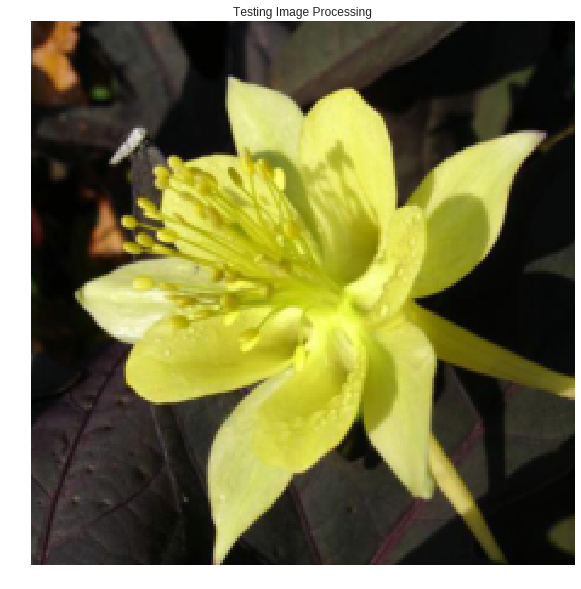

In [0]:
iterator = iter(train_loader)
x, y = next(iterator)
tensor = x[0]

# Displaying image
imshow(tensor, title='Testing Image Processing')

## Class Prediction

Once you can get images on the correct format, now we can move on to write a function that makes predictions given a model. The function will predict the top-$K$  probable classes.

In [0]:
def predict(image, model, topk=5):
  assert type(image) is str or torch.Tensor, "Image should be either a path or a tensor."
  
  model.eval()
  
  if type(image) is str:
    image = process_image(image)

    # Converting to tensor
    tensor_image = torch.from_numpy(image)
    tensor_image = tensor_image.float()
  else:
    tensor_image = image.clone()
  
  if len(tensor_image.size()) == 3:
    tensor_image.unsqueeze_(0)
  
  # Prediction
  output = model(tensor_image)
  softmax = nn.Softmax(dim=1)
  output = softmax(output)
  
  # Getting topk
  probabilities, classes = output.topk(topk, dim=1)
  
  probabilities = probabilities.squeeze().detach().numpy()
  classes = classes.squeeze().detach().numpy()
  
  classes = np.array([str(c) for c in classes])
  
  return probabilities, classes

## Sanity Check

To look for obvious failures and test if the predictions of the model makes sense, the `sanity_check` function will display the prediction image together with the top-5 possible classes and the true label.

In [0]:
iterator = iter(valid_loader)
x, y = next(iterator)

In [0]:
def sanity_check(image, label, model):
  assert type(label) is str or torch.Tensor, 'Label must be either a string or a tensor'
  
  if type(label) is torch.Tensor:
    label = str(label.item())
    
  class_name = model.idx_to_class[label]
  
  # Making the predictions
  probabilities, classes = predict(image, model, topk=5)
  
  # Getting the name of the most probable classes
  classes_name = [model.idx_to_class[c] for c in classes]
  
  # Plotting the figure
  fig, (ax1, ax2) = plt.subplots(figsize=(9, 12), ncols=2)
  imshow(image, ax=ax1, title=class_name)
  
  ax2.barh(np.arange(5), probabilities)
  ax2.set_aspect(0.2)
  ax2.set_yticks(np.arange(5))
  
  ax2.set_yticklabels(classes_name, size='medium')
  
  ax2.set_title('Class Probability')
  ax2.set_xlim(0, 1.1)
  
  plt.tight_layout()

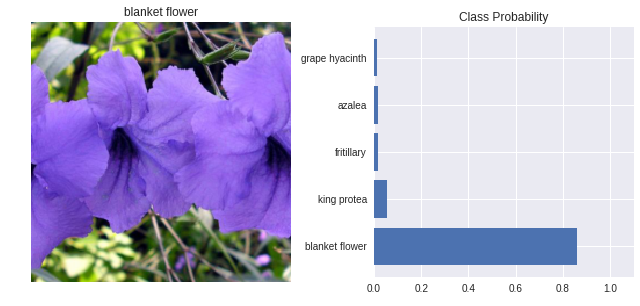

In [0]:
# Choosing which flower to check
batch_size = len(x)
random_number = np.random.randint(batch_size)
image, label = x[random_number], y[random_number]

# Sanity Check if everything's ok
sanity_check(image, label, model)

In [0]:
model.class_to_idx['columbine']

'84'